In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

from dataset import CustomImageDataset
from model import MLP

/home/aschieb/.cache/pypoetry/virtualenvs/interview-challenge-HeSA3_w6-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hyperparameters

In [2]:
learning_rate = 5e-5
epochs = 1000
batch_size = 16
dropout_prob=0.5

Dataset, data split, and DataLoaders.

In [3]:
full_ds = CustomImageDataset(list(range(400)), load_embeddings=True)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_ds, [0.7, 0.15, 0.15])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Multi Layer Perceptron

In [4]:
mlp = MLP(d_in=1024, d_hidden=128, d_out=4, dropout_prob=dropout_prob)
print(mlp)

MLP(
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=128, out_features=4, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
)


Training Loop

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate) 

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    # Train the model
    mlp.train()
    train_loss = 0.0
    for i, (embedding, label) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs =  mlp(embedding)
        loss = criterion(outputs, label)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * embedding.size(0)
    
    train_loss /= len(train_dataset)

    mlp.eval()
    val_loss = 0.0
    for i, (embedding, label) in enumerate(val_loader):                 
        # Forward pass
        outputs =  mlp(embedding)
        loss = criterion(outputs, label)
        val_loss += loss.item() * embedding.size(0)
    val_loss /= len(val_dataset)
    
    # Keep track of train/val loss for this epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)


100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]


Training/validation loss curves

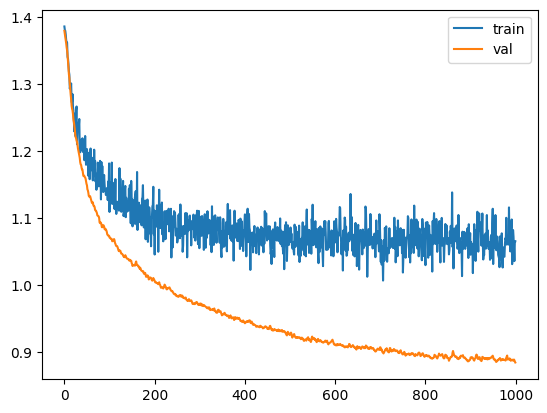

In [6]:
plt.plot(list(range(epochs)), train_losses)
plt.plot(list(range(epochs)), val_losses)
plt.legend(['train','val'])
plt.show()

Test the model on unseen data

In [7]:
mlp.eval()
preds = []
labels = []
for i, (embedding, label) in enumerate(test_dataset):
    pred_class = np.argmax(mlp(embedding).flatten().detach().numpy())
    label_class = np.argmax(label.detach().numpy())

    preds.append(pred_class)
    labels.append(label_class)

Evaluate the model on the test set

accuracy: 0.9


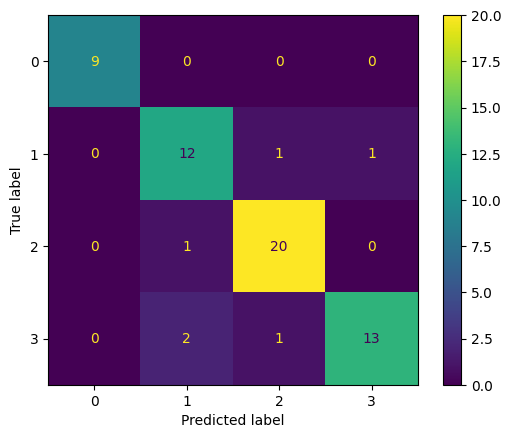

In [8]:
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm).plot()
print(f'accuracy: {accuracy_score(labels, preds)}')

Save the trained MLP

In [9]:
torch.save(mlp.state_dict(), 'mlp.pth')